# Naive QG Implementation

In [25]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb
from jaxsw._src.models.qg import qg_r as qg

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Equations

$$

$$

$$
\begin{aligned}
\partial_t q &= - \det\boldsymbol{J}(\psi,q) - \beta\partial_y\psi \\
q &= \nabla^2 \psi - \frac{1}{L_R^2}\psi \\
\psi &= \frac{f}{g} \\
u &= -\partial_y\psi \\
v &= \partial_x\psi \\
f &= 2\Omega\sin\theta_0 + \frac{1}{R}2\Omega\cos\theta_0 y
\end{aligned}
$$

where:
* $f_0=2\Omega\sin\theta_0$ is the Coriolis parameter at latitude $\theta_0$
* $\beta=\frac{1}{R}2\Omega\cos\theta_0 y$ is the $\beta$-plane approximation
* $L_R$ is the Rossby wave coefficient
* $\Omega$ is the angular frequency of rotation

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

## Read input SSH

In [26]:
ds = xr.open_dataset(
    "/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc"
)
ds = xr.open_dataset(
    "/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc",
    decode_times=False,
).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

In [27]:
lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T

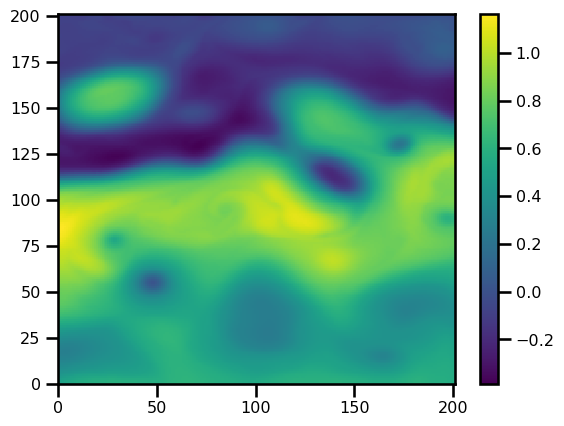

In [28]:
plt.figure()
plt.pcolormesh(ssh.T)
plt.colorbar()

In [29]:
def min_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.min(), arrays))
    return np.min(np.stack([*arrays], axis=0))


def max_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.max(), arrays))
    return np.max(np.stack([*arrays], axis=0))

## Looping

$$
\begin{aligned}
\psi^n &= f(\eta^n) \\
q^{n} &= f_2(\psi^n) \\
q^{n+1} &= q^{n} + \Delta t \hspace{1mm}\mathbf{rhs}(\psi, q) \\
\psi^{n+1} &= \text{Solve}(q^{n+1})
\end{aligned}
$$

In [30]:
from jaxopt.linear_solve import solve_cg


def pv_to_streamfn(q, dx, dy, c1=1.5, tol=1e-10, accuracy: int = 1):
    def matvec_A(x):
        return qg.streamfn_to_pvort(x, dx, dy, c1=c1, accuracy=accuracy)

    psi = solve_cg(matvec=matvec_A, b=q, tol=tol)

    return psi

In [32]:
lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T

dx, dy, f = qg.lat_lon_deltas(lon, lat)
nx, ny = len(lon), len(lat)
dx = dy = jnp.mean(jnp.asarray([dx, dy]))
f0 = np.asarray(np.mean(f))
dt = 600  # 10 mins / 600 s
c1 = 2.7  # 25_000 #1.5
g = 9.91
tol = 1e-15
upwind = False
beta = False

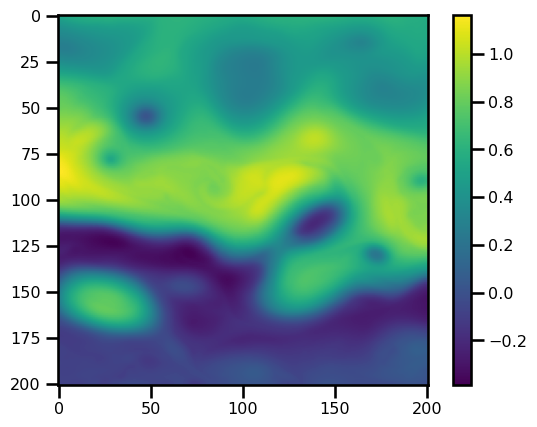

In [33]:
pts = plt.imshow(ssh.T)
plt.colorbar(pts)

In [34]:
# calculate stream function
psi = qg.ssh_to_streamfn(ssh=ssh, f0=f0)

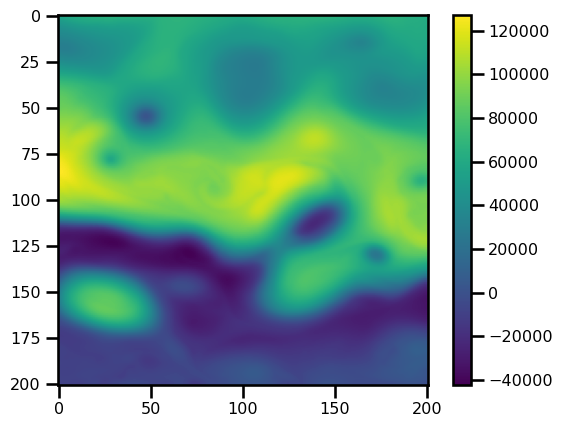

In [35]:
pts = plt.imshow(psi.T)
plt.colorbar(pts)

In [36]:
# calculate potential vorticity
q = qg.streamfn_to_pvort(psi=psi, dx=dx, dy=dy, c1=c1)

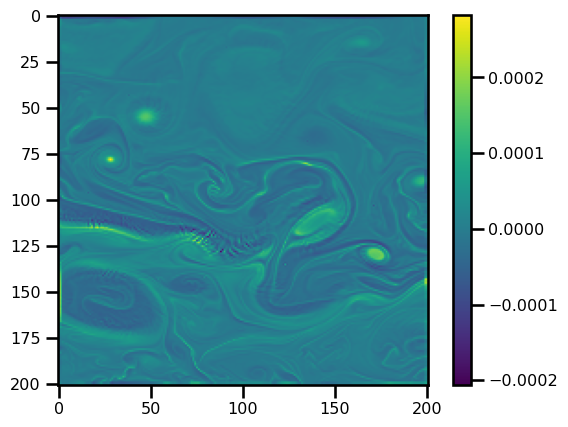

In [37]:
pts = plt.imshow(q.T)
plt.colorbar(pts)

In [39]:
# calculate RHS (advection, beta terms)
rhs = qg.rhs_fn(q=q, psi=psi, dx=dx, dy=dy, f0=f0, way=way, upwind=False, beta=False)

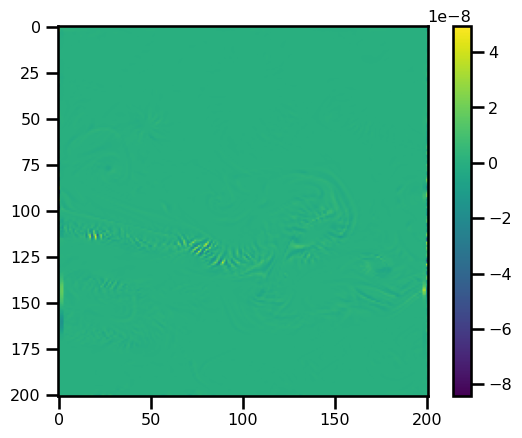

In [44]:
pts = plt.imshow(rhs.T)
plt.colorbar(pts)

In [45]:
# time step (Euler)
qnew = q + dt * rhs

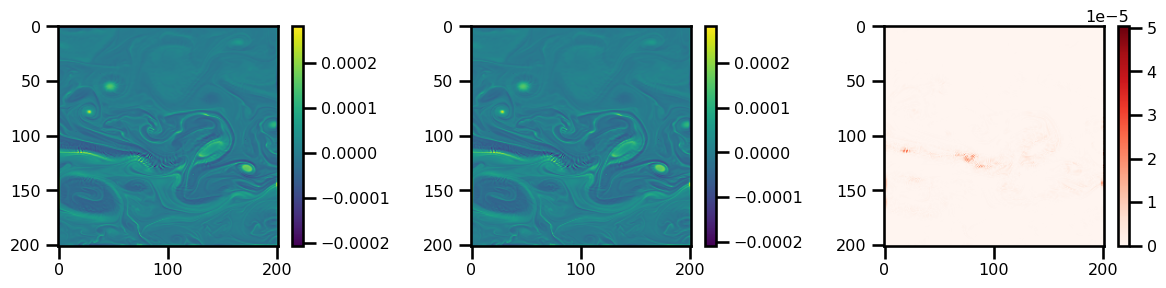

In [48]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

pts = ax[0].imshow(q.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[1].imshow(qnew.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[2].imshow(jnp.abs(q.T - qnew.T), cmap="Reds")
plt.colorbar(pts)


plt.tight_layout()
plt.show()

In [49]:
from jaxopt import linear_solve
from jaxsw._src.utils.linear_solver import conjugate_gradient, steepest_descent


def pv_to_streamfn(
    q: Array,
    psi_bc,
    dx,
    dy,
    tol: float = 1e-5,
    maxiters: int = 100,
    accuracy: int = 1,
) -> Array:
    # parse state, constants, steps

    # define matrix multiplcation term
    def matvec_Lp(psi):
        # psi = enforce_boundaries_psi(psi, psi_bc)
        q = qg.streamfn_to_pvort(psi, dx, dy, c1=c1, accuracy=accuracy)
        return q

    pnew = conjugate_gradient(
        q,
        matvec_fn=matvec_Lp,
        # u_init=p,
        target_criterion=tol,
        max_iterations=maxiters,
    ).u
    # pnew = linear_solve.solve_cg(matvec=matvec_Lp, b=q, tol=1e-5)

    return pnew


def enforce_boundaries_psi(u, u_bc):
    u = u.at[0, :].set(u_bc[0, :])
    u = u.at[-1, :].set(u_bc[-1, :])
    u = u.at[:, 0].set(u_bc[:, 0])
    u = u.at[:, -1].set(u_bc[:, -1])
    return u

In [50]:
# from jaxopt.linear_solve import solve_cg

# def pv_to_streamfn(q, dx, dy, c1=1.5, tol=1e-10, accuracy: int=1):

#     def matvec_A(x):
#         return qg.streamfn_to_pvort(x, dx, dy, c1=c1, accuracy=accuracy)

#     psi = solve_cg(matvec=matvec_A, b=q, tol=tol)

#     return psi

In [51]:
# calculate stream function
tol = 1e-10
maxiters = 10_000
out = pv_to_streamfn(q=q, psi_bc=psi, dx=dx, dy=dy, tol=tol, maxiters=maxiters)
# psi_new = pv_to_streamfn(q=qnew, dx=dx, dy=dy, tol=tol, maxiters=maxiters)

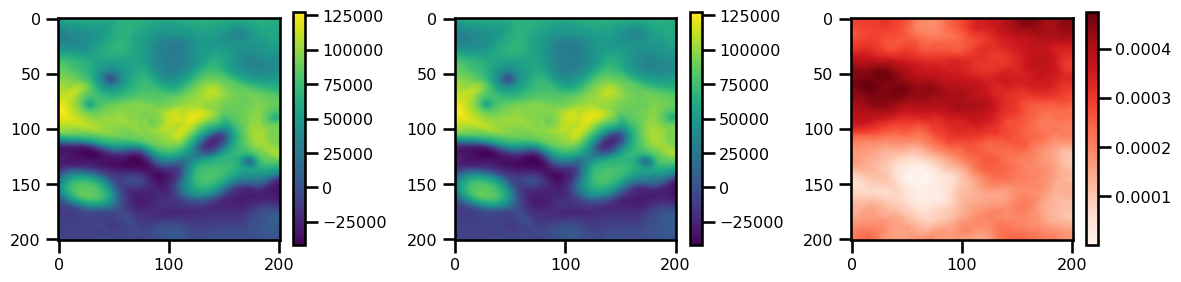

In [53]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

pts = ax[0].imshow(psi.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[1].imshow(out.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[2].imshow(jnp.abs(psi.T - out.T), cmap="Reds")
plt.colorbar(pts)


plt.tight_layout()
plt.show()

In [54]:
ssh_new = qg.streamfn_to_ssh(psi=out, f0=f0)

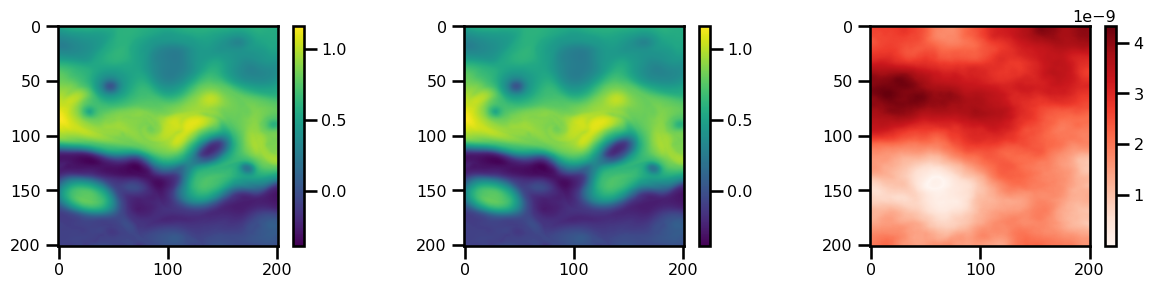

In [55]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

pts = ax[0].imshow(ssh.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[1].imshow(ssh_new.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[2].imshow(jnp.abs(ssh.T - ssh_new.T), cmap="Reds")
plt.colorbar(pts)


plt.tight_layout()
plt.show()

In [ ]:
# calculate RHS (advection, beta terms)
rhs = qg.rhs_fn(q=q, psi=psi, dx=dx, dy=dy, f0=f0, way=way, upwind=upwind, beta=beta)

# time step (Euler)
q = q + dt * rhs

# calculate stream function
psi = pv_to_streamfn(q=q, dx=dx, dy=dy, tol=tol, c1=c1)

# calculate ssh
ssh = qg.streamfn_to_ssh(psi=psi, f0=f0)
# print(ssh.min(), ssh.max())

In [57]:
from tqdm.autonotebook import trange

lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T

dx, dy, f = qg.lat_lon_deltas(lon, lat)
f0 = jnp.mean(f)
dt = 600  # 10 mins / 600 s
c1 = 25_000  # 1.5
way = 1
tol = 1e-10
maxiters = 10_000
n_iterations = 10
upwind = False
beta = False


def step(ssh):
    # calculate stream function
    psi = qg.ssh_to_streamfn(ssh=ssh, f0=f0)

    # calculate potential vorticity
    q = qg.streamfn_to_pvort(psi=psi, dx=dx, dy=dy, c1=c1)

    # calculate RHS (advection, beta terms)
    rhs = qg.rhs_fn(
        q=q, psi=psi, dx=dx, dy=dy, f0=f0, way=way, upwind=upwind, beta=beta
    )

    # time step (Euler)
    q = q + dt * rhs

    # calculate stream function
    # psi = pv_to_streamfn(q=q, dx=dx, dy=dy, tol=tol, c1=c1)
    out = pv_to_streamfn(q=q, psi_bc=psi, dx=dx, dy=dy, tol=tol, maxiters=maxiters)

    # calculate ssh
    ssh = qg.streamfn_to_ssh(psi=psi, f0=f0)
    # print(ssh.min(), ssh.max())
    return ssh


step = jax.jit(step)


for iteration in trange(n_iterations):
    ssh = step(ssh)

  0%|          | 0/10 [00:00<?, ?it/s]

In [58]:
ssh.min(), ssh.max()

(Array(-0.38488853, dtype=float64), Array(1.16310116, dtype=float64))

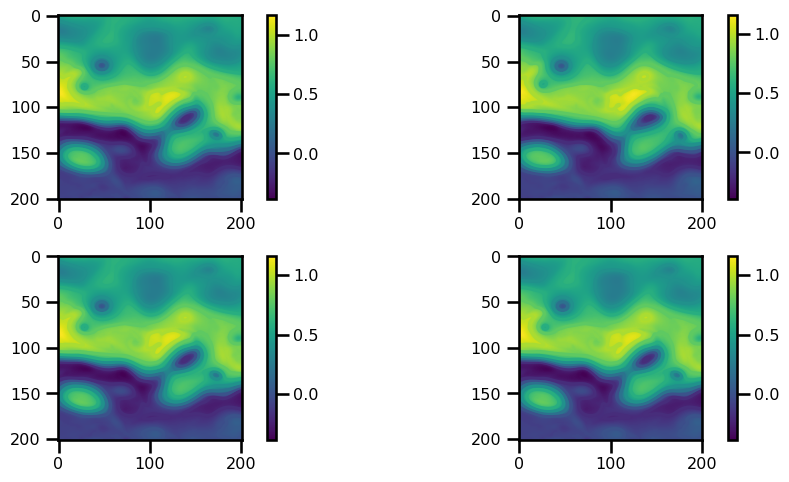

In [61]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

#
ax[0, 0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0, 0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0, 1].contour(ds.ssh[1].values, cmap="viridis")
pts = ax[0, 1].imshow(ds.ssh[1].values, cmap="viridis")
plt.colorbar(pts)


ax[1, 0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[1, 0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[1, 1].contour(ssh.T, cmap="viridis")
pts = ax[1, 1].imshow(ssh.T, cmap="viridis")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

In [64]:
from tqdm.autonotebook import trange

lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T

dx, dy, f0 = qg.lat_lon_deltas(lon, lat)
dt = 600  # 10 mins / 600 s
c1 = 1.5
way = 1
tol = 1e-15
n_iterations = 143 * 20
upwind = False
beta = False


def step(ssh):
    # calculate stream function
    psi = qg.ssh_to_streamfn(ssh=ssh, f0=f0)

    # calculate potential vorticity
    q = qg.streamfn_to_pvort(psi=psi, dx=dx, dy=dy, c1=c1)

    # calculate RHS (advection, beta terms)
    rhs = qg.rhs_fn(
        q=q, psi=psi, dx=dx, dy=dy, f0=f0, way=way, upwind=upwind, beta=beta
    )

    # time step (Euler)
    q = q + dt * rhs

    # calculate stream function
    out = pv_to_streamfn(q=q, psi_bc=psi, dx=dx, dy=dy, tol=tol, maxiters=maxiters)

    # calculate ssh
    ssh = qg.streamfn_to_ssh(psi=psi, f0=f0)
    # print(ssh.min(), ssh.max())
    return ssh


step = jax.jit(step)


for iteration in trange(n_iterations):
    ssh = step(ssh)

  0%|          | 0/2860 [00:00<?, ?it/s]

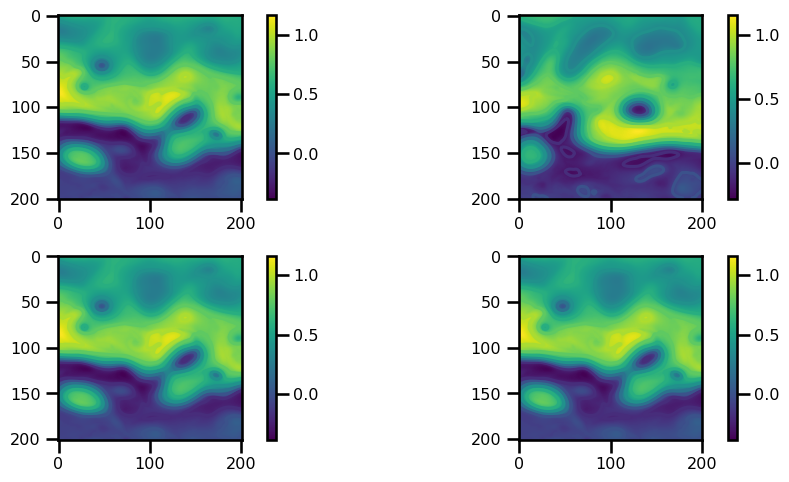

In [65]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

#
ax[0, 0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0, 0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0, 1].contour(ds.ssh[20].values, cmap="viridis")
pts = ax[0, 1].imshow(ds.ssh[20].values, cmap="viridis")
plt.colorbar(pts)


ax[1, 0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[1, 0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[1, 1].contour(ssh.T, cmap="viridis")
pts = ax[1, 1].imshow(ssh.T, cmap="viridis")
plt.colorbar(pts)

plt.tight_layout()
plt.show()